In [78]:
min (1,2)

1

In [45]:
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LightSource
from matplotlib.cm import get_cmap
from matplotlib.patches import Rectangle, Polygon


from mpl_toolkits.basemap import Basemap

import numpy as np

import cartopy.crs as crs
import cartopy._crs as _ccrs
from cartopy.feature import NaturalEarthFeature

import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy,get_basemap, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

import warnings
warnings.filterwarnings("ignore")

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def carga_var(data,name_var,time,lev_var,ini = 0,end = 305):
    if name_var != '0':
        if (type (name_var)== str) and (type(time) == int):

            var = getvar(data,name_var, timeidx = time)

            if len (var.shape)>2: var = var[lev_var,...]
            smooth_var = smooth2d(var, 3, cenweight=4)
        else:
            print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                  Si no escribis ts por default es 0 \033[0m""")
            return 0
        
    else:
        smooth_var = 0
    
    return smooth_var
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

def carga_v_rain(data, i,lev_viento = 0, lev_rich = 15, modo = 'normal',
          viento = False,sep_barb = 2, lluvia = False, topografia = False,
          ini =0,end = 305 , var_lluvia = 'RAINNC'): 
    """""""""""""""""""""""""""""""""VIENTO"""""""""""""""""""""""""""""""""
    if viento == True:
        if modo == 'presion': var_viento = ['U_PL', 'V_PL']
        elif lev_viento ==0: var_viento = ['U10', 'V10']
        else: var_viento = ['U', 'V']
        print(var_viento)
        v_x = getvar(data, var_viento[0], timeidx= i ) 
        v_y = getvar(data, var_viento[1], timeidx= i) 
        
        if len(np.asarray(v_x).shape)==2: 
            v_x = v_x[ini:end,ini:end]
            v_y = v_y[ini:end,ini:end]
        else: 
            v_x = v_x[lev_viento, ini:end,ini:end]
            v_y = v_y[lev_viento, ini:end,ini:end]
        
        v = [v_x,v_y]
        
    else: v = 0
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""  
    """""""""""""""""""""""""""""LLUVIA"""""""""""""""""""""""""""""
    if lluvia == True:
        print(getvar(data,var_lluvia,timeidx = i).shape, ini,end)
        raini = getvar(data,var_lluvia,timeidx = i)[ini:end,ini:end]
        rain_ = getvar(data,var_lluvia,timeidx = i-1)[ini:end,ini:end]

        rain = raini-rain_
        
    else: rain = 0

    if modo == 'indices':
        if viento == False:
            v_x = getvar(data, 'U', timeidx= i ) [lev_viento,ini:end,ini:end]
            v_y = getvar(data, 'V', timeidx= i) [lev_viento,ini:end,ini:end]
        v_x,v_y = to_np(v_x), to_np(v_y)
        cape = np.array(getvar(data,'AFWA_CAPE', timeidx = i))[ini:end,ini:end]
        #cape = np.expand_dims(cape,axis = 0)
        #cape = np.repeat(cape,59,axis = 0) sirve para repetir la matriz en un tercer eje
        v_media = v_x**2+v_y**2
        ri = cape/v_media
        print(ri.max(),ri.min())
        print('Richardson activado')
    else: ri,cape =0,0
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    return to_np(v),rain, ri, cape

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w+0.2)/(r-l)
    figh = float(h+0.2)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
    
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def set_var (var):
    if len(var.shape) == 4: var_set = to_np(var[i,...])
    elif len(var.shape) == 3: var_set = to_np(var[i,...])
    else: var_set = to_np(var)
    return var

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def sombreado (x,y, var_somb,ax, ini = 0, end = 305, cmap_s = 'coolwarm', zorder = 0, k=1):
    
    var_s = set_var(var_somb)
    ps = ax.contourf(x, y, var_s[ini:end,ini:end]*k, cmap = plt.get_cmap(cmap_s),zorder = zorder)

    return ps

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def contorno (x,y, var_cont,ax, ini = 0, end = 305, cmap_c = 'hot_r', zorder = 1,ncont = 12):
    
    var_c = set_var(var_cont)
    
    c_min, c_max =np.min(var_c),np.max(var_c)

    clev=np.linspace(c_min,c_max,ncont)

    pc = ax.contour(x,y, var_c[ini:end,ini:end],clev, cmap = plt.get_cmap(cmap_c),zorder = zorder)
    clab = plt.clabel(pc,clev,fontsize=12,fmt='%.0f',colors='k')

    return pc
 
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def plot_viento(x,y,v,bm,ini=0,end=305,cmap_viento = 'no',zorder = 2):
                
    
    """""""""""""""CMAP VIENTO"""""""""""""""
    if cmap_viento == 'no':
        cdict = {
        'blue': [(0,1,0.5),(0.4,0.5,0.4) , (1, 1, 1)],
        'green': [(0,0,0.2),(0.4,0.2,0), (1, 0, 0)],
        'red': [(0,0,0) ,(0.4,0,0.4), (1, 1, 1)]}
        cmap_viento = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,10)
    """"""""""""""""""""""""""""""""""""""""""
    x_v = x[0,:]
    y_v = y[:,0]

    v_x = to_np(v[0])[ini:end,ini:end]
    v_y = to_np(v[1])[ini:end,ini:end]
    
    speed = np.sqrt((v_x*2) ** 2 + (v_y*2) ** 2)
    lw = 3*speed / speed.max()

    vi= bm.streamplot(y_v, x_v, v_x, v_y, color = speed , density=1.5
                     ,cmap = cmap_viento , linewidth= lw, arrowsize = 1.5,
                         arrowstyle = '->', zorder = zorder)
        
    
    return vi

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def plot_precip(x,y, rain, bm, ini=0,end = 305, cmap_lluvia='raibow', zorder = 3):
    
    r = np.ma.array(rain, mask= rain < 0.5)
    ra = bm.contourf(x,y,r[ini:end,ini:end], cmap = plt.get_cmap(cmap_lluvia),zorder = zorder)
    return ra    

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def plot_recuadro(x,ax = False, ancho= 0.1,alto=0.1):
    lats = [-34,-32,-32,-34]
    lons = [-65,-65,-63,-63]
    x,y = ax(lats,lons)
    xy = zip(x,y)
    currentAxis = plt.gca()
    poly = Polygon( list(xy), facecolor='red', alpha=0.4 )
    currentAxis.add_patch(poly)
    #plt.gca().add_patch(poly)
    #else:   currentAxis = ax
    #currentAxis.add_patch(Rectangle((  0.5 - ancho/2, 0.5 - alto/2), ancho, alto, fill = False, alpha=1,linewidth=3))
    
    
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def info(var = '0',lev = '0', viento = False, lluvia = False, topografia=False):

    string = ''
    if var != '0':
        string = string + var + str(lev) 
    
    elif (viento and lluvia and topografia): string = 'No'
    else:
        if viento: 
            string = string + 'Viento en ' + str (lev)
        if lluvia: 
            string = string + ', Lluvia activada '
        if topografia:
            string = string + ', Topografía activada'

    return string

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
##############################################################################
##############################################################################
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def mapa_somb_cont2(path = '../../../../media/agustin/Linux/salidas_wrf/test01/',
                   archivo = 'wrfout_d02_2018-11-10_12:00:00', modo = 'normal',
                   ini = 0, end = 100,rows = 2,cols = 2,
                   var_s = '0',  ts = [0],   lev_s = 0  , us = 0 , cmap_s = 'coolwarm', 
                   var_c1 = '0', lev_c1 = 0 , uc1 = 0, cmap_c1 = 'hot_r', 
                   var_c2 = '0', lev_c2 = 0 , uc2 = 0, cmap_2 = 0, cmap_c2 = 'winter',
                   viento = True, lev_viento = 0,sep_barb = 1,cmap_viento = 'no',
                   titulo = 'Sin titulo definido', guardar = False,
                   topografia = True, topo_mode = 'soft',
                   lluvia = True, cmap_lluvia = 'gist_ncar',
                   lev_rich = 15
                   ):   
    if type(ts) != list: ts = [ts]
    """CARGA DE DATOS"""
    data = Dataset(path+archivo,'r')

    lats, lons = getvar(data,'XLAT'), getvar(data,'XLONG')
    if topografia==True: topo = np.asarray(getvar(data,'HGT'))
    times =  data.variables['Times']
    
    tiempos = []
    if np.asarray(lats).shape[0] <= end or np.asarray(lons).shape[0] <= end:
        end = min(np.asarray(lats).shape[0],np.asarray(lons).shape[0])-1
        
    if np.any(np.asarray(ts)>=len(times)):
        for i in range (len(ts)):
            ts[i] = i*len(times)//len(ts) -1
            
    for j,i in enumerate(ts):    
        tiempos.append( ''.join(str(times[i]).replace('b','').replace("'",'').replace('[','').replace(']','').replace('\n','').replace(' ','')))
    
    if modo == 'normal':
        print ('Mapa con límites lat: %f - %f, lon: %f - %f. \n Variables: %s somb, %s cont 1, %s cont 2,  %s. \n Archivo: %s. \n Tiempos: '
          %(lats[ini,ini], lats[end,end], lons[ini,ini], lons[end,end], 
            info(var_s,lev_s), info(var_c1,lev_c1),info(var_c2,lev_c2),
            info(viento = viento, lev = lev_viento, lluvia = lluvia, topografia = topografia),archivo), tiempos)
    else: 
        print('Modo %s'%modo)
    
    # Cargo el basemap de las latitudes
    bm = get_basemap(lats[ini:end,ini:end])
        
    x, y = bm(to_np(lons)[ini:end,ini:end], to_np(lats)[ini:end,ini:end])
    

    if len(ts)!= rows*cols:
        if np.sqrt(len(ts)) == round(np.sqrt(len(ts))):
            rows = int(np.sqrt(len(ts)))
            cols = rows
        else: 
            rows = int(np.sqrt(len(ts)))+1
            cols = rows
                
    #Guardo los nombres de las variables
    n_var_s, n_var_c1, n_var_c2 = var_s, var_c1, var_c2
    
    if modo == 'indices': 
        n_var_s = 'AFWA_CAPE'
        n_var_c2 = 'Richarson'
    
    lozada = [-31.651943,-64.07947] #Lat Lon de Lozada, Córdoba
    
    lats, lons = np.array(lats),np.array(lons)
    
    print('Lozada: ',lats[lats == lozada[0]], lons[lons == lozada[1]])

    ###############################
    ######  GENERO LA IMAGEN ######
    ###############################
    
    fig = plt.figure(figsize= (6,6))#,constrained_layout=True)
    axx = []
    for i, j in zip(ts,range(len(ts))):
        
        ## Un subplot por cada mapa uso las rows cols y la enumeración j
        ax = fig.add_subplot(int(rows*100+cols*10 + j+1))
        
        
        #Aca guardo los subplots
        axx.append(ax)
        
        """""""""""""""FUNCION DE CARGA DE DATOS"""""""""""""""
        
        ## Esta carga las cosas raras
        v,rain, ri, cape = carga_v_rain(data = data, i = i,lev_viento = lev_viento, lev_rich=lev_rich, modo = modo,
                              viento = viento, sep_barb = sep_barb, lluvia = lluvia, ini =ini,end = end)
        
        ## Esta carga las cosas comunes

        if modo == 'normal' or modo =='presion': 
            smooth_var_s  = carga_var(data,n_var_s,i ,lev_s,ini,end)
            smooth_var_c2 = carga_var(data,n_var_c2,i, lev_c2,ini,end)
        
        elif modo == 'indices':
            smooth_var_s = cape
            smooth_var_c2 = ri
            
        smooth_var_c1 = carga_var(data,n_var_c1,i,lev_c1,ini,end)
        

        ## Me genero los bools para despues ver que grafico y que no
        if type(smooth_var_s) == int: somb = False
        else: somb = True
        if type(smooth_var_c1) == int: cont1 = False
        else: cont1 = True
        if type(smooth_var_c2) == int: cont2 = False
        else: cont2 = True
        
        

        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""ACA EMPIEZA EL MAPA"""""""""
        # DEINO DIA Y HORA
        l=i%24
        d=int(i/24)+12 

        """""""""""""""GRAFICO SOMBREADO"""""""""""""""
        if somb == True or modo == 'indices':
           
            ps = sombreado(x,y, smooth_var_s,ax,ini =ini, end = end,cmap_s= cmap_s)

            ###TOPOGRAFÍA EN CONTORNO###
        if topografia == True: 
            ax.contour(x,y, topo,cmap = 'gray_r', linewidths = 2, zorder = 0)
                
        """""""""""""""""""""GRAFICO CONTORNO 1"""""""""""""""""""""
        if cont1 == True:
            
            pc1 = contorno(x,y, smooth_var_c1,ax, ini =ini, end = end, cmap_c = cmap_c1, zorder = 1,ncont = 12)
            
        """""""""""""""""""""GRAFICO CONTORNO 2"""""""""""""""""""""
        if cont2 == True or modo =='indices':

            pc2 = contorno(x,y, smooth_var_c2,ax, ini =ini, end = end, cmap_c = cmap_c2, zorder = 1,ncont = 12)
            plt.colorbar(pc2)
        """""""""""""""""""""""""""GRAFICO VIENTO"""""""""""""""""""""""""""
        if viento == True:
            
            vi = plot_viento(x,y,v,bm,ini,end,cmap_viento=cmap_viento,zorder= 4)
            
            
        """""""""""""""""""""""""""""LLUVIA"""""""""""""""""""""""""""""
        if lluvia == True:
            
            ra = plot_precip(x,y, rain, bm, ini,end, cmap_lluvia, zorder = 3)


        """""""""""""""BASEMAP"""""""""""""""""""""""""""""""""""""""""""""
        bm.drawcoastlines(linewidth=0.25)
        bm.drawstates(linewidth=1)
        bm.drawcountries(linewidth=0.25)
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """
        #plot_recuadro(lozada,ax =bm)

        #if recuadro != [-1,-1]:
            #plot_recuadro(recuadro,)

        ax.add_patch(Rectangle((lats[100,100],lons[100,100] ), 1, 1, fill = False, alpha=1))
       """
            
        ## Muestro los tiempos de cada plot para ver donde se corta por cualquier error
        print(tiempos[j] + ' OK')
        
        ## Titulo de cada gráfico
        ax.set_title("\n %s" %tiempos[j], fontsize = 12)

        titulo_ = titulo.replace(' ','').replace('(','').replace(')','').replace('/','')
        
    if guardar==True: plt.savefig("img/"+titulo_+"%s-utc" %(tiempos[j]),format='png')

    ##################################
    #Esto es para que quede acomodado#
    ##################################
    fig.tight_layout()
    set_size(12,10)
    ##################################
    
    ##################################
    ###"""ACA VAN LAS COLORBARS """###
    ##################################
    if somb == True: 
        caxv = plt.axes([0.98, 0.05, 0.02, 0.85])
        cbars = fig.colorbar(ps, ax=axx,cax=caxv, orientation = 'vertical')
        cbars.ax.set_ylabel(n_var_s + ' (%s)' %data.variables[n_var_s].units,fontsize = 12)
    if viento == True:
        caxh = plt.axes([0.05, -0.1, 0.9, 0.02])
        cbarv = fig.colorbar(vi.lines,ax=axx,cax=caxh, orientation = 'horizontal')    
        cbarv.ax.set_xlabel('Velocidad del viento (%s)' %data.variables['U10'].units, fontsize = 12)
    if lluvia == True:
        caxh2 = plt.axes([0.05, -0.02, 0.9, 0.02])
        cbar = fig.colorbar(ra, ax = axx, cax = caxh2 ,orientation = 'horizontal')
        cbar.ax.set_xlabel('Lluvia (%s)' %data.variables['RAINNC'].units, fontsize = 12)
    ###################################
    
    ## El titulo de toda la imagen
    fig.suptitle(titulo+ '\n',fontsize = 16, y = 1)
    plt.show()
    data.close()
    
        
"""
EJEMPLO DE MAPA 
---------------
mapa_somb_cont2( archivo='wrfout_d02_2018-11-10_12:00:00' , var_s = 'QVAPOR',lev_s=3,var_c1='TH2',
                guardar=False,ini = 0, end = 305,rows = 2, cols = 2,
                ts = [0,11,23,35],tc1 = 10, lluvia= True, topografia=True,
                titulo='$\Theta$ (cont - K - 2m) - Qv (somb - kg/kg - 2m) V sup - Lluvia (mm/hr)',
                cmap_s = 'BrBG',cmap_c1='hot_r', viento = True,
                cmap_lluvia = 'rainbow')
"""               


"\nEJEMPLO DE MAPA \n---------------\nmapa_somb_cont2( archivo='wrfout_d02_2018-11-10_12:00:00' , var_s = 'QVAPOR',lev_s=3,var_c1='TH2',\n                guardar=False,ini = 0, end = 305,rows = 2, cols = 2,\n                ts = [0,11,23,35],tc1 = 10, lluvia= True, topografia=True,\n                titulo='$\\Theta$ (cont - K - 2m) - Qv (somb - kg/kg - 2m) V sup - Lluvia (mm/hr)',\n                cmap_s = 'BrBG',cmap_c1='hot_r', viento = True,\n                cmap_lluvia = 'rainbow')\n"

In [86]:
archivos = !ls ../../../../media/agustin/Linux/salidas_wrf/test01
archivos

['wrfafwa_d01_2018-11-10_00:00:00',
 'wrfafwa_d01_2018-11-10_12:00:00',
 'wrfafwa_d01_2018-11-11_00:00:00',
 'wrfafwa_d01_2018-11-11_12:00:00',
 'wrfafwa_d02_2018-11-10_00:00:00',
 'wrfafwa_d02_2018-11-10_12:00:00',
 'wrfafwa_d02_2018-11-11_00:00:00',
 'wrfafwa_d02_2018-11-11_12:00:00',
 'wrfout_d01_2018-11-10_00:00:00',
 'wrfout_d01_2018-11-10_12:00:00',
 'wrfout_d01_2018-11-11_00:00:00',
 'wrfout_d01_2018-11-11_12:00:00',
 'wrfout_d02_2018-11-10_00:00:00',
 'wrfout_d02_2018-11-10_12:00:00',
 'wrfout_d02_2018-11-11_00:00:00',
 'wrfout_d02_2018-11-11_12:00:00',
 'wrfout_d02_RAINNC.nc',
 'wrfout_d02_U10-V10-Q2.nc',
 'wrfpress_d01_2018-11-10_00:00:00',
 'wrfpress_d01_2018-11-10_12:00:00',
 'wrfpress_d01_2018-11-11_00:00:00',
 'wrfpress_d01_2018-11-11_12:00:00',
 'wrfpress_d02_2018-11-10_00:00:00',
 'wrfpress_d02_2018-11-10_12:00:00',
 'wrfpress_d02_2018-11-11_00:00:00',
 'wrfpress_d02_2018-11-11_12:00:00',
 'wrfrst_d01_2018-11-10_12:00:00',
 'wrfrst_d01_2018-11-11_00:00:00',
 'wrfrst_d01

In [21]:
archivo =  "wrfout_d02_2018-11-11_12:00:00"
path = "/home/agustin/TESIS/Datos/"

## Gráfico QVAPOR a 2 m somb - Tita a 2 m cont - Viento en streamlines a 0 m - Lluvia horaria  

Mapa con límites lat: -35.328461 - -30.769745, lon: -66.662933 - -61.660980. 
 Variables: Q20 somb, TH20 cont 1,  cont 2,  Viento en 0, Lluvia activada . 
 Archivo: wrfout_d02_2018-11-11_12:00:00. 
 Tiempos:  ['2018-11-11_12:00:00']
Lozada:  [-31.651943] [-64.07947]
(305, 305) 0 304
2018-11-11_12:00:00 OK


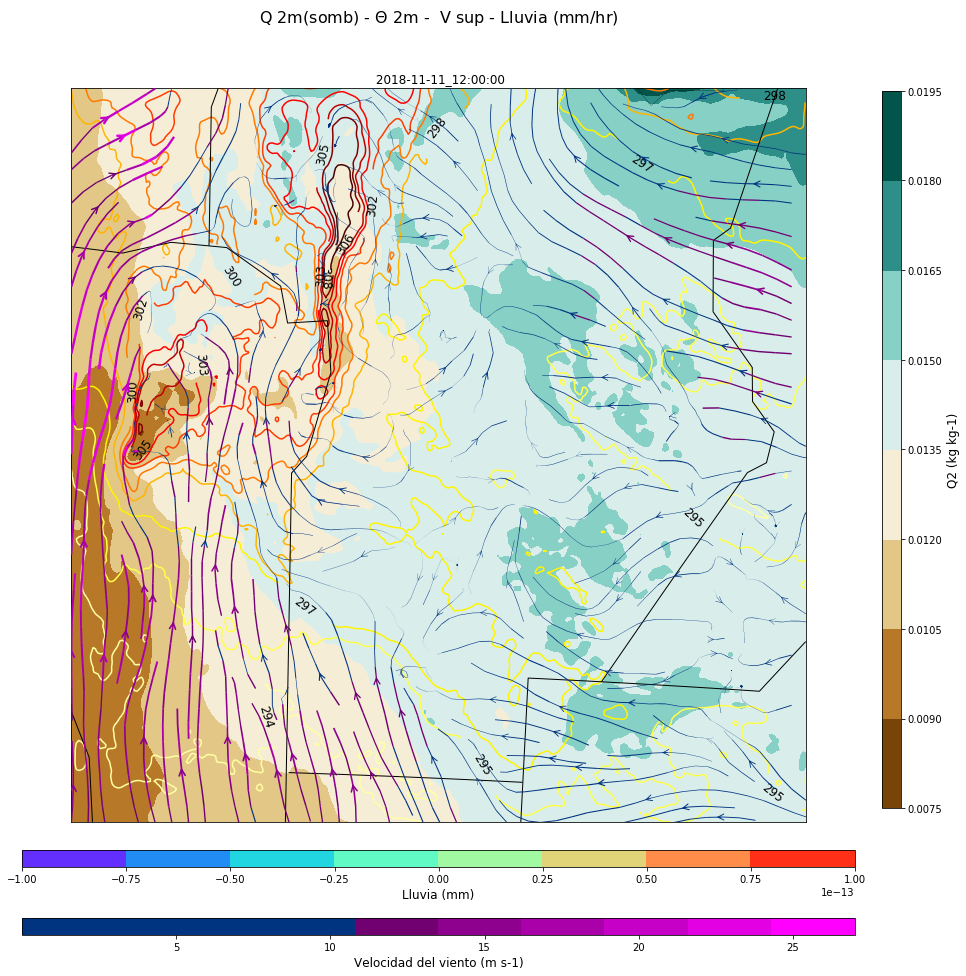

In [22]:
#for t in [0,4,8,12,16,20,24,28,32,36,40,44]:
t = 0
#for k in [10,15,20,25,30,35,40]:
mapa_somb_cont2(path="/home/agustin/TESIS/Datos/", archivo=archivo,var_s='Q2',
                var_c1='TH2',
                guardar=False,ini = 0, end = 304,rows = 1, cols = 1,
                ts = [t], lluvia= True, topografia=False, modo = 'normal', #lev_rich=k,
                titulo="Q 2m(somb) - $\Theta$ 2m -  V sup - Lluvia (mm/hr)",
                cmap_s = 'BrBG',cmap_c1='hot_r', viento = True,
                cmap_lluvia = 'rainbow')

## Gráfico de índices

In [ ]:
for k in [10,15,20,25,30,35,40]:
    mapa_somb_cont2(path="/home/agustin/TESIS/Datos/", archivo=archivo,#var_s='Q2',
                #var_c1='TH2',
                guardar=False,ini = 0, end = 304,rows = 1, cols = 1,
                ts = [t], lluvia= True, topografia=False, modo = 'indices', lev_rich=k,
                titulo="Q 2m(somb) - $\Theta$ 2m -  V sup - Lluvia (mm/hr)",
                cmap_s = 'viridis',cmap_c1='hot_r', viento = True,
                cmap_lluvia = 'rainbow')

Mapa con límites lat: -35.328461 - -30.769745, lon: -66.662933 - -61.660980. 
 Variables: Q20 somb,  cont 1,  cont 2,  Viento en 0, Lluvia activada . 
 Tiempos:  ['2018-11-11_02:15:00', '2018-11-11_04:15:00', '2018-11-11_06:15:00', '2018-11-11_08:15:00']
Lozada:  [-31.651943] [-64.07947]
(304, 304) (304, 304)
Richardson activado
2018-11-11_02:15:00 OK
(304, 304) (304, 304)
Richardson activado
2018-11-11_04:15:00 OK
(304, 304) (304, 304)
Richardson activado
2018-11-11_06:15:00 OK
(304, 304) (304, 304)
Richardson activado
2018-11-11_08:15:00 OK


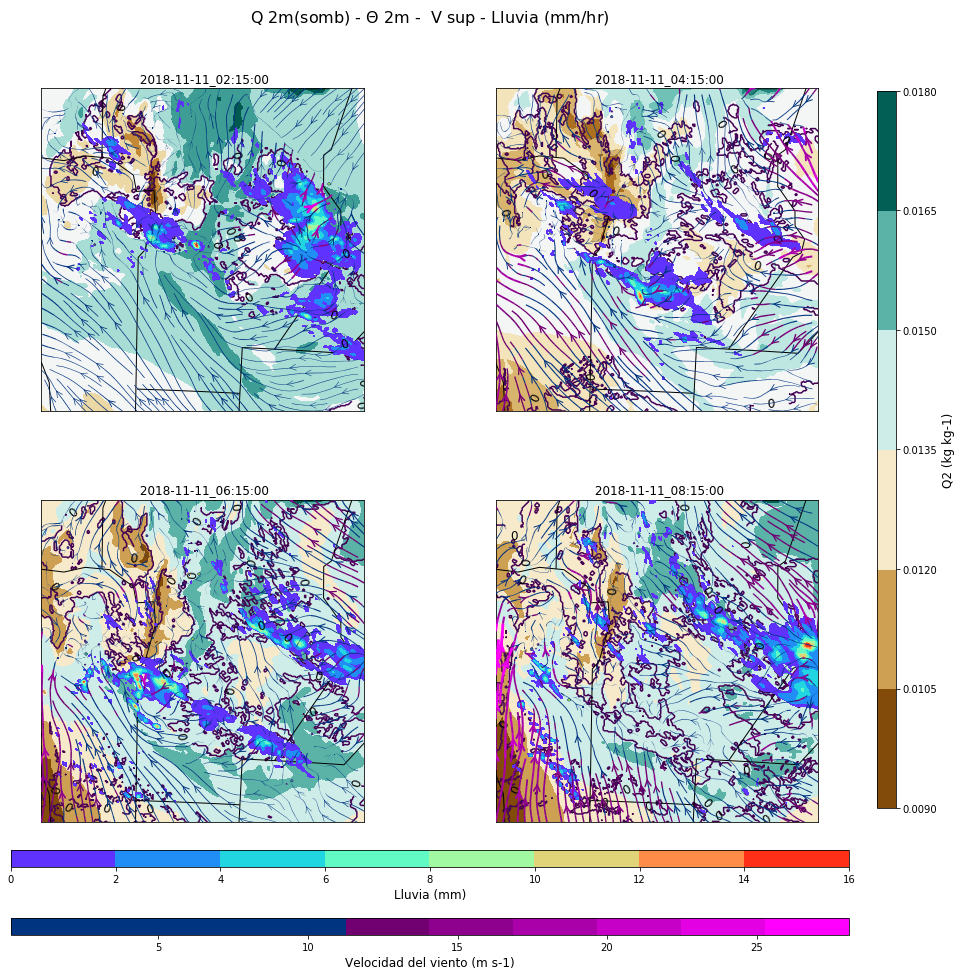

In [262]:
for t in [1]:
    mapa_somb_cont2( archivo='wrfout_d02_2018-11-11_00:00:00',var_s='Q2',
                    #var_c1='TH2',
                    guardar=False,ini = 0, end = 304,rows = 1, cols = 1,
                    ts = [t+8,t+16,t+24,t+32], lluvia= True, topografia=False, richardson = True, lev_rich=25,
                    titulo="Q 2m(somb) - $\Theta$ 2m -  V sup - Lluvia (mm/hr)",
                    cmap_s = 'BrBG',cmap_c1='hot_r', viento = True,
                    cmap_lluvia = 'rainbow')

In [23]:
archivo

'wrfout_d02_2018-11-11_12:00:00'

## Gráfico en 500hPa 

Modo presion
Lozada:  [-31.651943] [-64.07947]
['U_PL', 'V_PL']
2018-11-11_00:00:00 OK


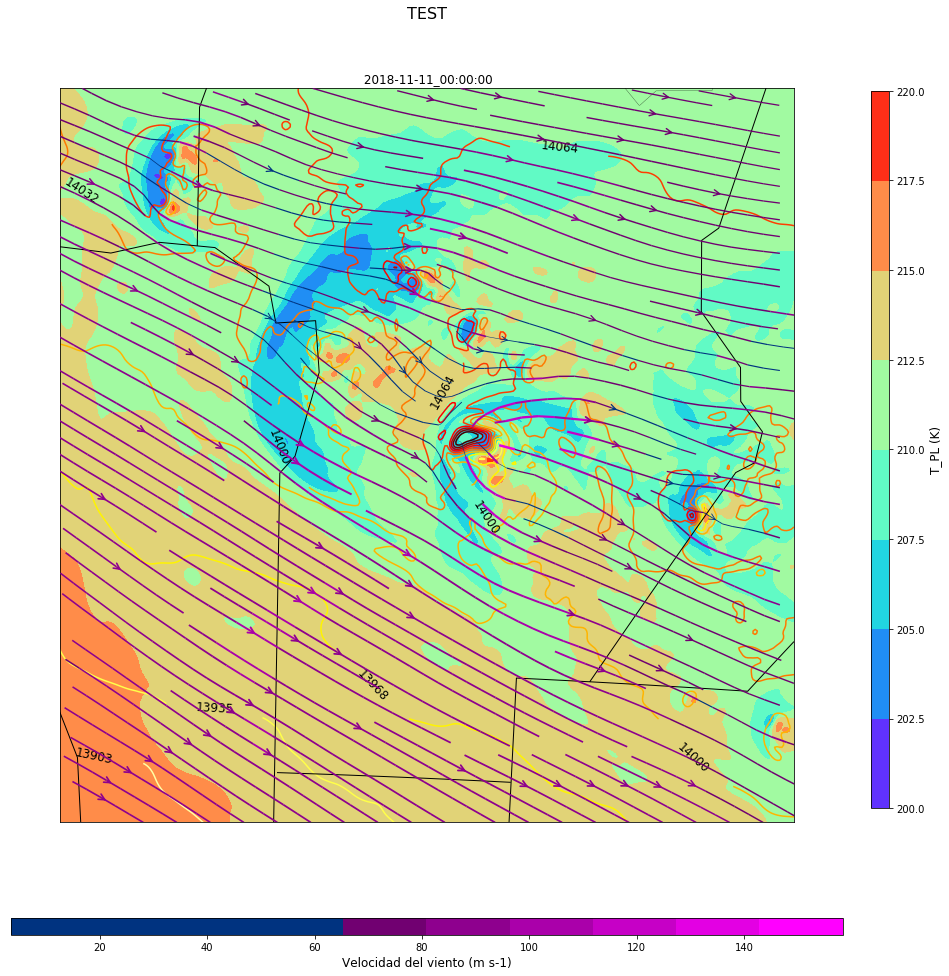

In [49]:
#for t in [0,4,8,12,16,20,24,28,32,36,40,44]:
t = 0
#for k in [10,15,20,25,30,35,40]:
#archivo ='wrfout_d02_2018-11-11_12:00:00'
mapa_somb_cont2(path="/home/agustin/TESIS/Datos/", archivo='wrfpress_d02_2018-11-11_00:00:00',var_s='T_PL', lev_s=20,
                var_c1='GHT_PL',lev_c1=20,#var_c2 = 'Q_PL', lev_c2=20,cmap_c2='jet',
                guardar=False,ini = 0, end = 304,rows = 1, cols = 1,
                ts = [t], lluvia= False, topografia=False, modo = 'presion', 
                titulo="TEST",
                cmap_s = 'rainbow',cmap_c1='hot_r', viento = True,lev_viento=20,
                cmap_lluvia = 'rainbow')

In [38]:
path = '/home/agustin/TESIS/Datos/'
#archivo = 'wrfout_d02_2018-11-10_12:00:00'
arch = 'wrfpress_d02_2018-11-11_00:00:00'
data = Dataset(path+arch,'r')

print(data.variables.keys())
print(data.variables['C1H'])
for i in range (len(data.variables['P_PL'][0])):
    print(i, data.variables['P_PL'][0][i])

odict_keys(['Times', 'XLAT', 'XLONG', 'Q2', 'T2', 'U10', 'V10', 'P_PL', 'U_PL', 'V_PL', 'T_PL', 'RH_PL', 'GHT_PL', 'S_PL', 'TD_PL', 'Q_PL', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F'])
<class 'netCDF4._netCDF4.Variable'>
float32 C1H(Time, bottom_top)
    FieldType: 104
    MemoryOrder: Z  
    description: half levels, c1h = d bf / d eta, using znw
    units: Dimensionless
    stagger: 
unlimited dimensions: Time
current shape = (48, 59)
filling on, default _FillValue of 9.969209968386869e+36 used

0 100000.0
1 97500.0
2 95000.0
3 92500.0
4 90000.0
5 87500.0
6 85000.0
7 80000.0
8 75000.0
9 70000.0
10 65000.0
11 60000.0
12 55000.0
13 50000.0
14 45000.0
15 40000.0
16 35000.0
17 30000.0
18 25000.0
19 20000.0
20 15000.0
21 10000.0
22 5000.0
23 2500.0
24 1000.0


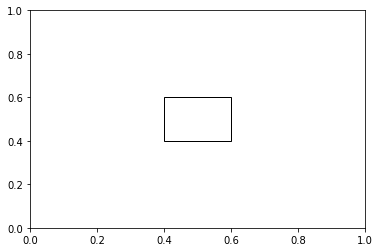

In [96]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
someX, someY = 0.5, 0.5
fig = plt.figure()
ax = fig.add_subplot(111)
#currentAxis = plt.gca()
ax.add_patch(Rectangle((someX - .1, someY - .1), 0.2, 0.2, fill = False, alpha=1))
plt.show()

## Gráfico de corte vertical 

(1, 305, 305)


Text(0.5, 1.0, 'Corte vertical longitudinal - lat = -33.103386')

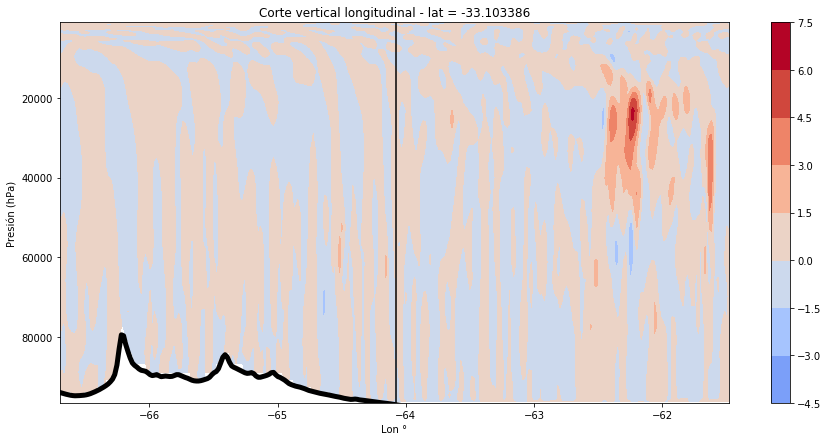

In [10]:
#path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
#archivo ='wrfout_d02_2018-11-10_12:00:00'
data = Dataset(path + archivo,'r')
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
from matplotlib.patches import Rectangle 
#opress = data.variables['P_PL']
#ot = data.variables['T_PL']
#ow = data.variables['']
opress = data.variables['P']
opressb = data.variables['PB']

ot = data.variables['T']
otb = data.variables['T00']

ow = data.variables['W']
oh = data.variables['HGT']

lats = data.variables['XLAT']
lons = data.variables['XLONG']

topo = np.asarray(data.variables['HGT'])
lozada = [-31.651943,-64.07947] #Lat Lon de Lozada, Córdoba

i = 150

press = opress[0,:,i,i] + opressb[0,:,i,i]

t = ot[0,:,i,:] +290

w = ow[0,:-1,i,:]

topografia = np.asarray(list(map(lambda x: -1.225*9.8*x+101300 ,topo)))

lon2D, press2D = np.meshgrid(lons[0,i,:], press)


fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(111)

for j in range(305):

    w[:,j] = np.ma.array(w[:,j], mask= press2D[:,j] > topografia[0,i,j])
    
s = ax.contourf(lon2D,press2D,w, cmap = plt.get_cmap('coolwarm'),vmax =w.max(),vmin =-w.max())
plt.plot(lon2D[0,:],topografia[0,i,:],linewidth = 5, color = 'k' )

print(topografia.shape)
plt.vlines(lozada[1],ymin=97500.,ymax=1000)

plt.colorbar(s, extend ='both')

plt.ylim (96600.,1000)
plt.ylabel('Presión (hPa)')
#plt.xlim(lozada[1]-1.,lozada[1]+1)
plt.xlabel('Lon °')
plt.title('Corte vertical longitudinal - lat = %f'%lats[0,i,i])



## Gráfico Hovmoller de dzt y w (Para overshooting tops)

i = 150.000000 - j = 150.000000 


TypeError: Input z must be at least a 2x2 array.

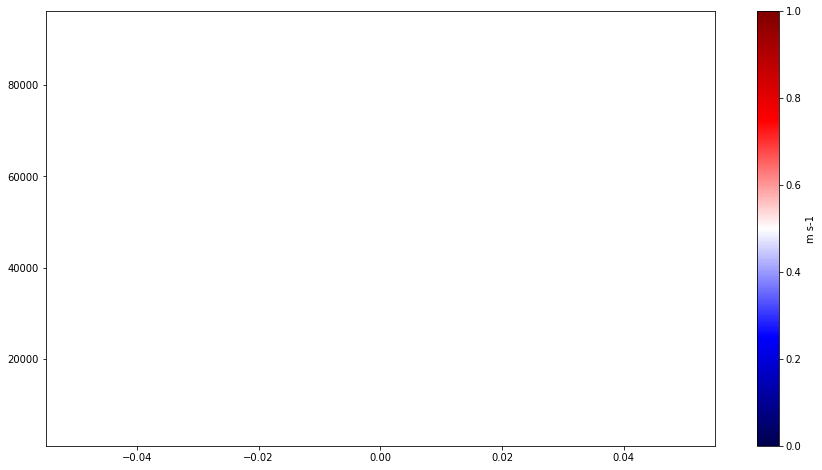

In [40]:


def hovmoller(i= 100,j= 100):
        """
        Solo sirve para muchos tiempos
        """
        opress = data.variables['P']
        opressb = data.variables['PB']

        ot = data.variables['T']
        otb = data.variables['T00']

        ow = data.variables['W']
        oh = data.variables['HGT']

        lats = data.variables['XLAT']
        lons = data.variables['XLONG']

        topo = np.asarray(data.variables['HGT'])
        lozada = [-31.651943,-64.07947] #Lat Lon de Lozada, Córdoba

        i, j = 150, 150 
        
        print('i = %f - j = %f '%(i,j))
        dz = opress.shape[1]
        press = opress[0,:,j,i] + opressb[0,:,j,i]

        t = ot[:,:,j,i] + 290.

        w = ow[:,1:,j,i]
        wu = ow.units
        dzt = t[:,1:dz]  - t[:,0:dz-1]


        time = np.arange(t.shape[0])
        time2D, press2D = np.meshgrid(time, press)

        pmin = press.min()
        pmax = press.max()

        fig = plt.figure(figsize=(15,8))
        ax = fig.add_subplot(111)
        ww = ax.pcolor(time2D, press2D, w.transpose(), cmap=plt.get_cmap('seismic'),zorder = -1)
        cbar = plt.colorbar(ww)
        cbar.set_label(wu)

        var_c = dzt.transpose()

        ncont = 20

        c_min, c_max =np.min(var_c),np.max(var_c)

        clev=np.linspace(c_min,c_max,ncont)

        c = ax.contour(time2D[1:dz,:], press2D[1:dz,:], var_c ,clev, color='k' ,linestyles=np.where(clev >= 0, "-", "--"))
        clab = plt.clabel(c,clev,fontsize=12,fmt='%.0f',colors='k')




        
        #bbox = dict( alpha =0, lw=2)
    
        #disp = ax.annotate('.',(10,10),
        #            xycoords='axes points',fontsize = 15,
        
        #            bbox=bbox)

        #disp.set_bbox(dict(facecolor='red', alpha=0.1, lw = 4))
        
        plt.ylim(50000.,10000.)
        plt.xlabel('time')
        plt.ylabel('press')
        plt.show()

hovmoller()



## Ploteo del cliclo completo Overshoot definiendo la tropo

Derivada vert de tita =~ 0

Diagnósticos hovmoller de dT/dz(:,:,i,j) en somb y w en cont para el punto de lozada

1)
6 simulaciones

mapas 2d sup: v10, u10, t2 
mapas 2d indices: cape, rich 
mapas 2d 500hpa: z, u,v,qvap, qcloud
mapas 2d w-e: qvapor, hgt, v con press
hovmoller:  dzt, w

2) tracking de la celda PENSAR ESTO  max precip, max w

3 ) repetir hovmoller con 2)

hasta aca para dentro de 2 semanas
4) caracterizacion de la supercelda:
Frente de rafagas, coldpool, ascendente, precip, overshoot, rotacion del mesociclón, spliting

Lozada:  [-31.651943] [-64.07947]
221


TypeError: carga_var() takes 4 positional arguments but 6 were given

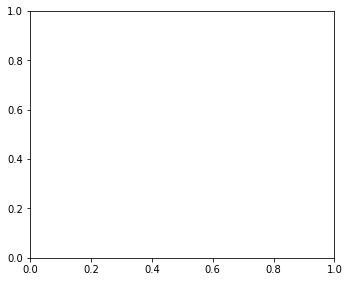

In [107]:
for t in [1]:
    mapa_somb_cont2( archivo='wrfout_d02_2018-11-11_00:00:00', var_s='Q2',
                    var_c1='TH2',
                    guardar=False,ini = 0, end = 305,rows = 2, cols = 2,
                    ts = [t,t+4,t+8,t+12],tc1 = 10, lluvia= True, topografia=False,
                    titulo="$\Theta$'(somb) - V sup (m/s) - Lluvia (mm/hr)",
                    cmap_s = 'BrBG',cmap_c1='hot_r', viento = True,
                    cmap_lluvia = 'rainbow', barb = False)

In [92]:
path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
archivo = 'wrfout_d02_2018-11-10_12:00:00'

data = Dataset(path+archivo,'r')

print(data.variables['TH2'],data.variables['RAINC'],data.variables['RAINSH'],data.variables['RADARVIL'])


<class 'netCDF4._netCDF4.Variable'>
float32 TH2(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: POT TEMP at 2 M
    units: K
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (48, 305, 305)
filling on, default _FillValue of 9.969209968386869e+36 used
 <class 'netCDF4._netCDF4.Variable'>
float32 RAINC(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: ACCUMULATED TOTAL CUMULUS PRECIPITATION
    units: mm
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (48, 305, 305)
filling on, default _FillValue of 9.969209968386869e+36 used
 <class 'netCDF4._netCDF4.Variable'>
float32 RAINSH(Time, south_north, west_east)
    FieldType: 104
    MemoryOrder: XY 
    description: ACCUMULATED SHALLOW CUMULUS PRECIPITATION
    units: mm
    stagger: 
    coordinates: XLONG XLAT XTIME
unlimited dimensions: Time
current shape = (48, 305, 305)
filling o

In [23]:
ri = cape/v_media

In [29]:
print(np.max(ri))
#for i in range(40):
 #   plt.imshow(ri[i,25,:,:])
  #  plt.show()

649535.9


In [69]:
lat = data.variables['XLAT']
lat = np.array(lat)
lat[(lat<-30) & (lat>-35)]

array([-34.999363, -34.99833 , -34.997288, ..., -30.77171 , -30.770725,
       -30.769745], dtype=float32)

In [55]:
path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
archivo = 'wrfout_d02_2018-11-10_12:00:00'

data = Dataset(path+archivo,'r')

data.variables[]

OrderedDict([('Times', <class 'netCDF4._netCDF4.Variable'>
              |S1 Times(Time, DateStrLen)
              unlimited dimensions: Time
              current shape = (48, 19)
              filling on, default _FillValue of   used),
             ('XLAT', <class 'netCDF4._netCDF4.Variable'>
              float32 XLAT(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LATITUDE, SOUTH IS NEGATIVE
                  units: degree_north
                  stagger: 
                  coordinates: XLONG XLAT
              unlimited dimensions: Time
              current shape = (48, 305, 305)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('XLONG', <class 'netCDF4._netCDF4.Variable'>
              float32 XLONG(Time, south_north, west_east)
                  FieldType: 104
                  MemoryOrder: XY 
                  description: LONGITUDE, WEST IS NEGATIVE
     

In [173]:
            
        """        if topografia == True: 
            #print('Topografía OK')
            dx = 111200*np.asarray(data.variables['XLONG'][0,:,0])*np.cos(np.radians(np.min(topo)))
            dy = 111200*np.asarray(data.variables['XLAT'][0,0,:])
            ls = LightSource(azdeg=315, altdeg=45)
            cmap2 = plt.cm.gist_earth
            ve = 1    """
        
############################################################
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""TOPOGRAFÍA EN SOMBREADO SI NO HAY CONTOURF""""""""" 
        """if topografia == True and somb == False:
            top = ls.hillshade(topo, vert_exag=ve, dx=dx, dy=dy)
            ax.contourf(top[ini:end,ini:end], cmap='gray')
            rgb = ls.shade(topo, cmap=plt.get_cmap('Greys'), blend_mode=topo_mode,
                           vert_exag=ve, dx=dx, dy=dy)
            ax.imshow(rgb)
       """
        
        ##############################################################
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

['2018-11-10_12:00:00', '2018-11-10_12:15:00', '2018-11-10_12:30:00']

In [16]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

import matplotlib as mpl
from matplotlib.colors import LightSource

import cartopy.crs as crs
import cartopy._crs as _ccrs

from matplotlib.cm import get_cmap
from cartopy.feature import NaturalEarthFeature

from wrf import (to_np, getvar, smooth2d, get_cartopy,get_basemap, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import wrf



def mapa_somb_cont2(path = '../../../../media/agustin/Linux/salidas_wrf/test01/',
                   archivo = 'wrfout_d02_2018-11-10_12:00:00',
                   var_s = '0',  ts = 0,   lev_s = 0  , us = 0 , cmap_s = 'coolwarm', 
                   var_c1 = '0', tc1 = -1, lev_c1 = 0 , uc1 = 0, cmap_c1 = 0,
                   var_c2 = '0', tc2 = -1, lev_c2 = 0 , uc2 = 0, cmap_2 = 0,
                   viento = False, lev_viento = 0,sep_barb = 1,viento_cmap = 'Blues',
                   titulo = 'Sin titulo definido', guardar = False,
                   topografia = True, topo_mode = 'soft',
                   lluvia = True
                   ):
    
    """CARGA DE DATOS"""
    data = Dataset(path+archivo,'r')

    lats, lons, topo = getvar(data,'XLAT'), getvar(data,'XLONG'), np.asarray(getvar(data,'HGT'))
    
    bm = get_basemap(lats)
    
    """""""""""""""CMAP VIENTO"""""""""""""""
    cdict = {'blue': [(0, 0, 1),(0.5,1,0.5) , (1, 1, 1)],
    'green': [(0, 0, 1), (0.5,0.3,0), (1, 0, 0)],
    'red': [(0, 0, 1) ,(0.5,0.1,0.5) , (1, 1, 1)]}

    cmap_lluvia = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,50)
    
    """"""""""""""""""""""""""""""""""""""""""

    
    if tc1 == -1: tc1 = ts
    if tc2 == -1: tc2 = ts
    if lev_c1 == -1: lev_c1 = lev_s
    if lev_c2 == -1: lev_c2 = lev_s
    
    ks,kc1,kc2,   = 1, 1, 1
    n_var_s, n_var_c1, n_var_c2 = var_s, var_c1, var_c2
    lozada = [-31.651943,-64.07947]

    
    for i in ts:
        """""""""SOMBREADO"""""""""
        if n_var_s != '0':
            if (type (n_var_s)== str) and (type(i) == int):
                print(n_var_s + ' OK')
                
                var_s = getvar(data,n_var_s, timeidx = i)#, units = us)# if type(us)==str else None)
                
                if len (var_s.shape)>2: var_s = var_s[lev_s,...]
                smooth_var_s = smooth2d(var_s, 3, cenweight=4)
                bm, somb = get_basemap(var_s), True
    
            else:
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis ts por default es 0 \033[0m""")
                return 0
        else: somb = False
        """"""""""""""""""""""""""""""""
        """""""""CONTORNO 1"""""""""
        if n_var_c1 != '0':
            if (type(n_var_c1) == str) and (type(i) == int):
                print(n_var_c1 +' OK')
                var_c1 = getvar(data,n_var_c1,timeidx= i)#, units = uc1 if type(uc1)==str else None)
                
                if len (var_c1.shape)>2: var_c1 = var_c1[lev_c1,...]
                smooth_var_c1 = smooth2d(var_c1, 3, cenweight=4)
                lats, lons = latlon_coords(var_c1)          
                bm, cont1 = get_basemap(var_c1), True

            else: 
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis tc1 por default es 0 \033[0m""")
                return 0
        else: cont1 = False
        """"""""""""""""""""""""""
        """""""""CONTORNO 2"""""""""
        if n_var_c2 != '0':
            if (type(n_var_c2)== str) and (type(i) == int):
                print(n_var_c2 + ' OK')

                var_c2 = getvar(data,n_var_c2,timeidx=i)#, units = uc2 if type(uc2)==str else None)
                
                if len (var_c2.shape)>2: var_c2 = var_c2[lev_c2,...]
                smooth_var_c2, cont2 = smooth2d(var_c2, 3, cenweight=4), True
                bm = get_basemap(var_c2)
            else: 
                print("""\033[1;32m La variable tiene que estar escrita como string y el tiempo como int \n 
                      Si no escribis tc2 por default es 0 \033[0m""")
                return 0
        else: cont2 = False
        """"""""""""""""""""""""""    
        """""""""""""""""""""""""""""""""VIENTO"""""""""""""""""""""""""""""""""
        if viento == True:
            print('Viento OK')
            a=sep_barb  
            v_x = getvar(data,'U', timeidx= i )[lev_viento,...]
            v_y = getvar(data, 'V', timeidx= i) [lev_viento,...]
        
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""  
        """""""""""""""""""""""""""""LLUVIA"""""""""""""""""""""""""""""
        if lluvia == True:
            
            raini = getvar(data,'RAINNC',timeidx = i)
            rain_ = getvar(data,'RAINNC',timeidx = i-1)

            rain = raini-rain_
            
        
        
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""""""""""TOPOGRAFIA"""""""""""""""""""""""""""""
        if topografia == True: 
            print('Topografía OK')
            dx = 111200*np.asarray(data.variables['XLONG'][0,:,0])*np.cos(np.radians(np.min(topo)))
            dy = 111200*np.asarray(data.variables['XLAT'][0,0,:])
            ls = LightSource(azdeg=315, altdeg=45)
            cmap2 = plt.cm.gist_earth
            ve = 1    
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""



    
        """""""""ACA EMPIEZA EL MAPA"""""""""
        # DEINO DIA Y HORA
        l=i%24
        d=int(i/24)+12 
        
        fig, ax = plt.subplots(1,figsize = (10,7))

        x, y = bm(to_np(lons), to_np(lats))
        """""""""""""""GRAFICO SOMBREADO"""""""""""""""
        if somb == True:
            if len(smooth_var_s.shape) == 3: var_s = to_np(smooth_var_s[i,...])
            else: var_s = to_np(smooth_var_s)

            ps = ax.contourf(x, y, var_s,15 , cmap = plt.get_cmap(cmap_s))
            cbar = bm.colorbar(ps, location = 'bottom', shrink=1, pad = 0.25) 
            cbar.ax.tick_params(labelsize=12, labelbottom = True , labelright = False)
            
            plt.xlabel(n_var_s)

            
            ###TOPOGRAFÍA EN CONTORNO###
            if topografia == True: bm.contour(x,y, topo,cmap = 'gray')
        """"""""""""""""""""""""""""""""""""""""""""""""""
        
        """""""""TOPOGRAFÍA EN SOMBREADO SI NO HAY CONTOURF"""""""""
        if topografia == True:
            top = ls.hillshade(topo, vert_exag=ve, dx=dx, dy=dy)
            bm.imshow(top, cmap='gray')
            rgb = ls.shade(topo, cmap=plt.get_cmap('Greys'), blend_mode=topo_mode,
                           vert_exag=ve, dx=dx, dy=dy)
            bm.imshow(rgb)
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""""""""""LLUVIA"""""""""""""""""""""""""""""
        if lluvia == True:
            
            plt.contour(x,y,rain)
        
        
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO CONTORNO 1"""""""""""""""""""""
        if cont1 == True:
            
            if len(smooth_var_c1.shape) == 3: var_c1 = to_np(smooth_var_c1[i,...])
            else: var_c1 = to_np(smooth_var_c1)

            c1_min, c1_max, ncont_1 =np.min(var_c1),np.max(var_c1), 15

            clev=np.linspace(c1_min,c1_max,ncont_1)
            pc1 = bm.contour(x,y, var_c1,clev, cmap = plt.get_cmap(cmap_c1))
            clab = plt.clabel(pc1,clev,fontsize=14,fmt='%.00f',colors='k')
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO CONTORNO 2"""""""""""""""""""""
        if cont2 == True:
            
            if len(smooth_var_c2.shape) == 3: var_c2 = to_np(smooth_var_c2[i,...])
            else: var_c2 = to_np(smooth_var_c2)
            pc2 = ax.contour(x,y, var_c2) 
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
        """""""""""""""""""""GRAFICO VIENTO"""""""""""""""""""""
        if viento == True:
            
            x_v = x[0,:]
            y_v = y[:,0]

            v_x = to_np(v_x[:,:-1])
            v_y = to_np(v_y[:-1,:])
            
            speed = np.sqrt((v_x*2) ** 2 + (v_y*2) ** 2)
            lw = 2*speed / speed.max()

            vi= bm.streamplot(y_v, x_v, v_x, v_y, color = speed, density = 1.5
                            ,cmap = cmap_lluvia , linewidth= lw, arrowsize = 1.5,
                             arrowsize)
            
            cbar_v = plt.colorbar(vi.lines,shrink = 1, pad = -0.2)
            
            cbar_v.ax.set_ylabel('Velocidad del viento')
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

        """""""""BASEMAP"""""""""""""""""""""""""""""""""""""""""""""
        bm.drawcoastlines(linewidth=0.25)
        bm.drawstates(linewidth=1)
        bm.drawcountries(linewidth=0.25)
        """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""        
        plt.tight_layout()
        plt.title(titulo+" %s-%s utc" %(l,d), fontsize = 16)

        if guardar==True:
            plt.savefig("img/"+titulo+"%s-%sutc" 
                        %(l,d),format='png')
        plt.show()
    data.close()
    
        
mapa_somb_cont2( var_s = 'QVAPOR',var_c1='TH2',topografia = False, 
                ts = [8,12,16],tc1 = 10, titulo='Temperatura a 2 m',
               cmap_s = 'BrBG',cmap_c1='hot_r', viento = True, viento_cmap='gist_ncar')
               


odict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'SHDMAX', 'SHDMIN', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'COSZEN', 'LAI', 'DTAUX3D', 'DTAUY3D', 'DUSFCG', 'DVSFCG', 'VAR', 'CON', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV', 'MAPFAC_VY', 'F', 'E', 'SINALPHA', 'C

(305,) (305,)
(305, 305)
(305, 305)
(305, 305)
(305, 305)
(305, 305)
(305, 305)


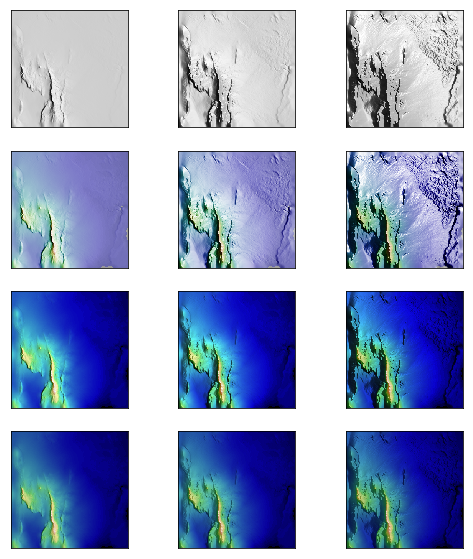

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource


path = '../../../../media/agustin/Linux/salidas_wrf/test01/'
archivo = 'wrfout_d02_2018-11-10_12:00:00'
data = Dataset(path+archivo,'r')

z = np.asarray(data.variables['HGT'][0,...])

#-- Optional dx and dy for accurate vertical exaggeration ----------------
# If you need topographically accurate vertical exaggeration, or you don't
# want to guess at what *vert_exag* should be, you'll need to specify the
# cellsize of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any
# *vert_exag* value you specify will be relative to the grid spacing of
# your input data (in other words, *dx* and *dy* default to 1.0, and
# *vert_exag* is calculated relative to those parameters).  Similarly, *dx*
# and *dy* are assumed to be in the same units as your input z-values.
# Therefore, we'll need to convert the given dx and dy from decimal degrees
# to meters.
dx, dy = np.asarray(data.variables['XLONG'][0,:,0]), np.asarray(data.variables['XLAT'][0,0,:])
print(dx.shape,dy.shape)
dy = 111200 * dy
dx = 111200 * dx * np.cos(np.radians(np.min(z)))
#-------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 9))
plt.setp(axes.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axes.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    print(z.shape)
    top = ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy)
    print(top.shape)
    col[0].imshow(top, cmap='gray')
    
    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

"""# Label rows and columns
for ax, ve in zip(axes[0], [0.1, 1, 10]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axes[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

"""# Group labels...
"""axes[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='center', va='bottom', size=20)
axes[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=20, rotation=90)
"""
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()

In [7]:
x,y = m(255,146)
x_,y_ = m(lat,lon)
#plt.subplot2grid((1,2),(0,0))
m.imshow(t[0,10,:,:],cmap=plt.get_cmap('coolwarm'))
m.scatter(146,255)#,s=1000)

#plt.scatter(x,y,marker='o',s=100,color='r')
m.drawparallels(np.arange(minlat,maxlat,5),labels = [0.5,0,0,0], fontsize = 10, linewidth = 0.4)
m.drawmeridians(np.arange(minlon,maxlon,10),labels=[0,0,0,0.3],fontsize = 10, linewidth = 0.4)
m.drawcoastlines(linewidth = 0.6)
m.drawcountries(linewidth = 0.5)
m.drawstates(linewidth = 0.4)
lon_ = lon[0,146]
lat_ = lat[255,0]
x,y = m(lon_, lat_)
loz = m.plot(x, y, 'bo', markersize=24)
#plt.plot(146,255,marker='o',color='r')

plt.show()

NameError: name 'm' is not defined

IndexError: too many indices

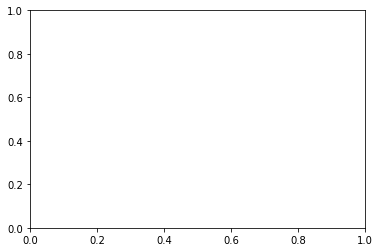

In [120]:
fig ,ax= plt.subplots(1)

dl=2.
[ptlat,ptlon] = [-31.651739700-dl/2.,-64.097784300-dl/2.]
plt.contourf(lon[0,:,:],lat[0,:,:],t[0,0,:,:])
plt.plot([ptlon,ptlon],[ptlat,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon,ptlon+dl],[ptlat+dl,ptlat+dl],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon+dl],[ptlat+dl,ptlat],'-k',linewidth=2)
plt.plot([ptlon+dl,ptlon],[ptlat,ptlat],'-k',linewidth=2)
#a= mpach.Rectangle((210,116),40,30,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(a)

plt.show()